In [107]:
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn import datasets
from sklearn.model_selection import train_test_split

In [108]:
DATASET_TYPE = "complex" # simple, complex
N_SAMPLES = 300
M = 1
EPOCHS = 5

In [109]:
def generate_examples(dataset_type = "simple", n_samples = N_SAMPLES, n_features = 1, noise = 20):

    np.random.seed(42)
    if dataset_type == "simple":
        X, t = datasets.make_regression(n_samples=n_samples, n_features=n_features, n_informative=1, noise=noise, random_state=37)
        return X, t
    
    elif dataset_type == "complex":
        n_samples = 300
        x = np.linspace(-10, 10, n_samples) # coordinates
        noise_sample = np.random.normal(0,0.5,n_samples)
        sine_wave = x + np.sin(4*x) + noise_sample
        x = np.reshape(x, (len(x), 1))
        return x, sine_wave
    else:
        raise ValueError("Unknown dataset type: " + dataset_type)

In [110]:
# Generam datele de test si train
# Folosind proportia 20/80 
X, t = generate_examples(dataset_type=DATASET_TYPE)
X_train, X_test, t_train, t_test = train_test_split(X, t, test_size=0.2, random_state=42)

In [111]:
def extract_polynomial_features(X, M):
    phi = X
    # TODO codul vostru aici: intoarceti valorile phi_n astfel incat pentru fiecare 
    # intrare x phi_n = [1, x, x^2, ..., x^M]
    phi_n = np.zeros((X.size, M+1))

    print(X[0])

    for i in range(X.size):
        current = np.zeros(M+1)

        for j in range(M+1):
            current[j] = X[i] ** j

        phi_n[i] = current
        # print(X[i][0], i)

    phi = phi_n
    # end
    
    # nota: phi trebuie sa fie la final un np.array de dimensiune (N, M+1), unde N este numarul de linii din X
    return phi

In [112]:
def extract_sinusoidal_features(X):

    sin_X = np.sin(4*X)
    
    return np.concatenate((X, sin_X), axis=1)

In [113]:
class RidgeRegression:
    def __init__(self, alpha):
        self.alpha = alpha
        
    def fit(self, X, t):
        n, m = X.shape
        X = np.hstack((np.ones((n, 1)), X))
        self.w = np.linalg.inv(X.T @ X + self.alpha*np.eye(m+1)) @ X.T @ t

        # Calculam variabila din laborator var
        self.var = np.mean(np.square(X @ self.w - t))

    def predict(self, X, return_std):
        n, m = X.shape
        X = np.hstack((np.ones((n, 1)), X))

        y = X @ self.w

        if return_std:
            # TODO codul vostru aici: intoarceti un vector de aceeasi dimensiune cu y, care 
            # are in fiecare pozitie o valoare egala cu deviatia standard a modelului antrenat (i.e. sqrt(var))
            y_std = np.ones_like(y) * math.sqrt(self.var)

            return y, y_std
        return y

    def score(self, X, t):
        y_pred = self.predict(X, False)
        u = ((t - y_pred) ** 2).sum()
        v = ((t - t.mean()) ** 2).sum()
        return 1 - u/v

In [114]:
# creati un model liniar
model = RidgeRegression(alpha=0.1)

# Folositi functia extract_polynomial_features pentru a introduce termenul de bias in matricile X_train si X_test
if(DATASET_TYPE == "complex"):
    X_train_feat = extract_sinusoidal_features(X_train)
    X_test_feat = extract_sinusoidal_features(X_test)
else:
    X_train_feat = extract_polynomial_features(X_train, M)
    X_test_feat = extract_polynomial_features(X_test, M)

# antrenati modelul vostru
model.fit(X_train_feat, t_train)

# obtineti predictia pe setul de antrenare si pe setul de test
y_train = model.predict(X_train_feat, False) 
y_train = np.zeros(X_train.size)
y_test = np.zeros(X_test.size)
y_test_std = np.zeros(X_test.size)
y_test, y_test_std = model.predict(X_test_feat, True)

# Sortam
sorted_stuffs = list(zip(*sorted(zip(X_test,y_test))))
X_test_sorted = sorted_stuffs[0]
y_test_sorted = sorted_stuffs[1]

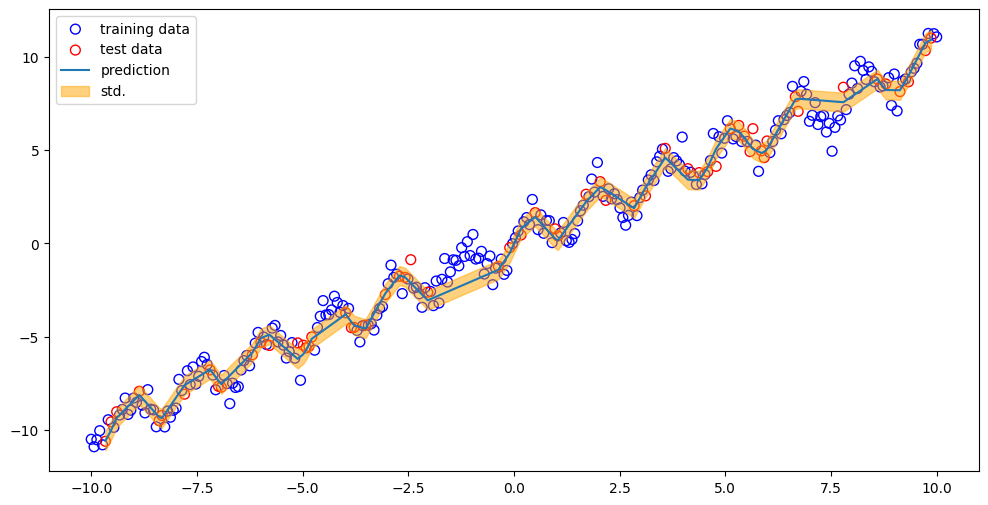

In [115]:
plt.figure(figsize=(12,6))
plt.scatter(X_train, t_train, facecolor="none", color="b", s=50, label="training data")
plt.scatter(X_test, t_test, facecolor="none", color="r", s=50, label="test data")
plt.plot(X_test_sorted, y_test_sorted, label="prediction")
plt.fill_between(
    np.squeeze(X_test_sorted), y_test_sorted - y_test_std, y_test_sorted + y_test_std,
    color="orange", alpha=0.5, label="std.")
plt.legend()
plt.show()

In [116]:
def k_fold_validation(model, X, y, k=5):
    n = len(X)
    fold_size = int(n/k)
    scores = []
    for i in range(k):
        start = i * fold_size
        end = (i+1) * fold_size
        X_test, y_test = X[start:end], y[start:end]
        X_train = np.concatenate([X[:start], X[end:]])
        y_train = np.concatenate([y[:start], y[end:]])
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test, False)
        scores.append(model.score(X_test, y_test))
    return scores

In [117]:
ridge = RidgeRegression(alpha=0.1)
scores = k_fold_validation(ridge, X_test, y_test)
print("Scores: ", scores)
print("Mean score: ", np.mean(scores))

Scores:  [0.9834937331137793, 0.9840860432744025, 0.9832289940795501, 0.9835392335992801, 0.9806729045393509]
Mean score:  0.9830041817212727
